In [1]:
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes #uncomment if geopy has not been installed 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes #uncomment if folium has not been installed 
import folium # map rendering library

#!pip install BeautifulSoup4
from urllib.request import urlopen
from bs4 import BeautifulSoup as bs
import ssl
import csv

import urllib.parse
import urllib.error
import ast
import os
from urllib.request import Request, urlopen

#to extract the csv file of latitude and longitude 
import io 

#to deal with regex - regular expressions
import re

#for some plots
import matplotlib.pyplot as plt

print('Libraries imported.')

Libraries imported.


In [2]:
#scrape neighborhoods in Minneapolis from wikipedia using BeautifulSoup as bs

url = requests.get("https://en.wikipedia.org/wiki/Category:Neighborhoods_in_Minneapolis")

soup = bs(url.text, "html.parser")

neighborhood = []
#hello
for link in soup.find_all("a"):
    neighbor = link.get("title")
    neighborhood.append(neighbor)

neighborhood = list(filter(None.__ne__, neighborhood)) #remove Nonetype in list of neighborhoods
neighborhood = pd.DataFrame(neighborhood)

#cleanup the neighborhood dataframe 
neighborhoodDict = {"neighborhood": []}
for row, neighbor in neighborhood.iterrows(): 
    if 'Minneapolis' in neighbor[0]:
        neighborhoodDict["neighborhood"].append(neighbor[0])

neighborhoodMinn = pd.DataFrame(neighborhoodDict)

#remove rows that are not neighborhoods
neighborhoodMinn = neighborhoodMinn.drop(neighborhoodMinn.index[[0, 1, 2, 3, 91, 92]]).reset_index(drop=True)

#cleanup some names of neighborhood in order to locate it later for latitude and longitude

exp = re.compile(r' \(neighborhood\)')
neighborhoodMinn['neighborhood'] = [exp.sub('', x) for x in neighborhoodMinn['neighborhood']]

#Mill District results in Nonetype latitude and longitude values so drop its row
neighborhoodMinn = neighborhoodMinn.drop(neighborhoodMinn.index[[51]]).reset_index(drop=True)

#remove Ventura Village because it's located outside Minneapolis - according to FourSquare API
neighborhoodMinn = neighborhoodMinn.drop(neighborhoodMinn.index[[76]]).reset_index(drop=True)

#Nicollet Island- East Bank, Minneapolis' returns a NoneType error, so therefore changed it to Nicollet Island
neighborhoodMinn['neighborhood'] = neighborhoodMinn['neighborhood'].replace(['Nicollet Island/East Bank, Minneapolis'],'Nicollet Island, Minneapolis')

neighborhoodMinn.head()

,neighborhood
0,"Armatage, Minneapolis"
1,"Audubon Park, Minneapolis"
2,"Bancroft, Minneapolis"
3,"Beltrami, Minneapolis"
4,"Bottineau, Minneapolis"


In [3]:
# NOTE TO MYSELF: DO NOT RUN THIS CODE CHUNK UNLESS NECESSARY

#this code block takes ~ 45 seconds on my machine due to having to locate latitude and longitude for 85 neighborhoods

latitude = []
longitude = []

geolocator = Nominatim(user_agent="minneapolis_explorer")
for row, neighbor in neighborhoodMinn.iterrows(): 
    location = geolocator.geocode(neighbor[0])
    latitude.append(location.latitude)
    longitude.append(location.longitude)

neighborhoodMinn['latitude'] = latitude
neighborhoodMinn['longitude'] = longitude
neighborhoodMinn.head()

,neighborhood,latitude,longitude
0,"Armatage, Minneapolis",44.897236,-93.310342
1,"Audubon Park, Minneapolis",45.018883,-93.236355
2,"Bancroft, Minneapolis",44.930570,-93.254929
3,"Beltrami, Minneapolis",44.995352,-93.242513
4,"Bottineau, Minneapolis",45.010566,-93.269304


In [4]:
CLIENT_ID = 'TN32UEOPQPWXMDYXAIEPZ3C4G0Q2XG1KOI3K4P5BNBV5NIVL' # your Foursquare ID
CLIENT_SECRET = 'VXCCMMIUMDRIBFPFRPFYT3VK43BHWZ5EIS5UIPVGMITSWDK1' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30

In [5]:
address = 'Minneapolis, Minnesota'
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Minneapolis are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Minneapolis are 44.9772995, -93.2654692.


In [6]:
# create map of Minneaplis using latitude and longitude values by neighborhood
map_minn_neighborhood = folium.Map(location = [latitude, longitude], zoom_start = 12)

# add markers to map
for lat, lng, neighborhood in zip(neighborhoodMinn['latitude'], neighborhoodMinn['longitude'], neighborhoodMinn['neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_minn_neighborhood)  
    
map_minn_neighborhood

In [7]:
neighborhood_df = pd.read_csv('neighborhoodData.csv')
neighborhood_df.head()  

,"Minneapolis, MN - All Homes",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,Statistic,NaN,NaN,Zillow Home Value Index,NaN,NaN,NaN,NaN,NaN
1,Region Name,Region Type,Type,Current,Month Over Month,Quarter Over Quarter,Year Over Year,5 Year Annualized,10 Year Annualized
2,Minneapolis,city,All Homes,"$291,500",0.30%,0.90%,3.30%,6.30%,3.90%
3,Armatage,neighborhood,All Homes,"$360,400",0.20%,0.50%,2.50%,5.10%,4.20%
4,Audubon Park,neighborhood,All Homes,"$289,500",0.40%,1.00%,6.20%,7.40%,4.50%


In [8]:
header_row = 1
neighborhood_df.columns = neighborhood_df.iloc[header_row]
neighborhood_df.head()

1,Region Name,Region Type,Type,Current,Month Over Month,Quarter Over Quarter,Year Over Year,5 Year Annualized,10 Year Annualized
0,Statistic,NaN,NaN,Zillow Home Value Index,NaN,NaN,NaN,NaN,NaN
1,Region Name,Region Type,Type,Current,Month Over Month,Quarter Over Quarter,Year Over Year,5 Year Annualized,10 Year Annualized
2,Minneapolis,city,All Homes,"$291,500",0.30%,0.90%,3.30%,6.30%,3.90%
3,Armatage,neighborhood,All Homes,"$360,400",0.20%,0.50%,2.50%,5.10%,4.20%
4,Audubon Park,neighborhood,All Homes,"$289,500",0.40%,1.00%,6.20%,7.40%,4.50%


In [9]:
neighborhood_df = neighborhood_df.drop(neighborhood_df.index[[0, 1, 2]]).reset_index(drop=True)
neighborhood_df.head()

1,Region Name,Region Type,Type,Current,Month Over Month,Quarter Over Quarter,Year Over Year,5 Year Annualized,10 Year Annualized
0,Armatage,neighborhood,All Homes,"$360,400",0.20%,0.50%,2.50%,5.10%,4.20%
1,Audubon Park,neighborhood,All Homes,"$289,500",0.40%,1.00%,6.20%,7.40%,4.50%
2,Bancroft,neighborhood,All Homes,"$275,200",0.20%,0.40%,0.90%,7.10%,4.40%
3,Beltrami,neighborhood,All Homes,"$256,000",0.20%,0.50%,2.20%,7.10%,4.00%
4,Bottineau,neighborhood,All Homes,"$282,100",0.50%,1.50%,6.10%,8.90%,5.40%


In [10]:
neighborhood_df.rename(columns = {neighborhood_df.columns[0]: 'neighborhood', neighborhood_df.columns[3]: 'zestimatedHVI', neighborhood_df.columns[4]: 'MoM', neighborhood_df.columns[5]: 'QoQ', neighborhood_df.columns[6]: 'YoY', neighborhood_df.columns[7]: 'fiveYearAnnualized', neighborhood_df.columns[8]: 'tenYearAnnualized'}, inplace = True)
neighborhood_df.head()

1,neighborhood,Region Type,Type,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized
0,Armatage,neighborhood,All Homes,"$360,400",0.20%,0.50%,2.50%,5.10%,4.20%
1,Audubon Park,neighborhood,All Homes,"$289,500",0.40%,1.00%,6.20%,7.40%,4.50%
2,Bancroft,neighborhood,All Homes,"$275,200",0.20%,0.40%,0.90%,7.10%,4.40%
3,Beltrami,neighborhood,All Homes,"$256,000",0.20%,0.50%,2.20%,7.10%,4.00%
4,Bottineau,neighborhood,All Homes,"$282,100",0.50%,1.50%,6.10%,8.90%,5.40%


In [11]:
neighborhood_df.drop(neighborhood_df.columns[[1, 2]], axis = 1, inplace = True)
neighborhood_df.head()

1,neighborhood,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized
0,Armatage,"$360,400",0.20%,0.50%,2.50%,5.10%,4.20%
1,Audubon Park,"$289,500",0.40%,1.00%,6.20%,7.40%,4.50%
2,Bancroft,"$275,200",0.20%,0.40%,0.90%,7.10%,4.40%
3,Beltrami,"$256,000",0.20%,0.50%,2.20%,7.10%,4.00%
4,Bottineau,"$282,100",0.50%,1.50%,6.10%,8.90%,5.40%


In [12]:
neighborhood_df['neighborhood'] = neighborhood_df['neighborhood'].astype(str) + ', Minneapolis'
neighborhood_df.head()

1,neighborhood,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized
0,"Armatage, Minneapolis","$360,400",0.20%,0.50%,2.50%,5.10%,4.20%
1,"Audubon Park, Minneapolis","$289,500",0.40%,1.00%,6.20%,7.40%,4.50%
2,"Bancroft, Minneapolis","$275,200",0.20%,0.40%,0.90%,7.10%,4.40%
3,"Beltrami, Minneapolis","$256,000",0.20%,0.50%,2.20%,7.10%,4.00%
4,"Bottineau, Minneapolis","$282,100",0.50%,1.50%,6.10%,8.90%,5.40%


In [13]:
exp = re.compile(r'[$,]')
neighborhood_df['zestimatedHVI'] = [exp.sub('', x) for x in neighborhood_df['zestimatedHVI']]
neighborhood_df.head()


1,neighborhood,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized
0,"Armatage, Minneapolis",360400,0.20%,0.50%,2.50%,5.10%,4.20%
1,"Audubon Park, Minneapolis",289500,0.40%,1.00%,6.20%,7.40%,4.50%
2,"Bancroft, Minneapolis",275200,0.20%,0.40%,0.90%,7.10%,4.40%
3,"Beltrami, Minneapolis",256000,0.20%,0.50%,2.20%,7.10%,4.00%
4,"Bottineau, Minneapolis",282100,0.50%,1.50%,6.10%,8.90%,5.40%


In [14]:
exp = re.compile(r'%')
neighborhood_df['MoM'] = [exp.sub('', x) for x in neighborhood_df['MoM']]
neighborhood_df['QoQ'] = [exp.sub('', x) for x in neighborhood_df['QoQ']]
neighborhood_df['YoY'] = [exp.sub('', x) for x in neighborhood_df['YoY']]
neighborhood_df['fiveYearAnnualized'] = [exp.sub('', x) for x in neighborhood_df['fiveYearAnnualized']]
neighborhood_df['tenYearAnnualized'] = [exp.sub('', x) for x in neighborhood_df['tenYearAnnualized']]

neighborhood_df.head()

1,neighborhood,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized
0,"Armatage, Minneapolis",360400,0.20,0.50,2.50,5.10,4.20
1,"Audubon Park, Minneapolis",289500,0.40,1.00,6.20,7.40,4.50
2,"Bancroft, Minneapolis",275200,0.20,0.40,0.90,7.10,4.40
3,"Beltrami, Minneapolis",256000,0.20,0.50,2.20,7.10,4.00
4,"Bottineau, Minneapolis",282100,0.50,1.50,6.10,8.90,5.40


In [15]:
neighborhood_df.dtypes

1
neighborhood          object
zestimatedHVI         object
MoM                   object
QoQ                   object
YoY                   object
fiveYearAnnualized    object
tenYearAnnualized     object
dtype: object

In [16]:
neighborhood_df[["zestimatedHVI", "MoM", "QoQ", "YoY", "fiveYearAnnualized", "tenYearAnnualized"]] = neighborhood_df[["zestimatedHVI", "MoM", "QoQ", "YoY", "fiveYearAnnualized", "tenYearAnnualized"]].apply(pd.to_numeric, errors = 'coerce')
neighborhood_df.dtypes

1
neighborhood           object
zestimatedHVI           int64
MoM                   float64
QoQ                   float64
YoY                   float64
fiveYearAnnualized    float64
tenYearAnnualized     float64
dtype: object

In [17]:
neighborhood_df.head()

1,neighborhood,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized
0,"Armatage, Minneapolis",360400,0.2,0.5,2.5,5.1,4.2
1,"Audubon Park, Minneapolis",289500,0.4,1.0,6.2,7.4,4.5
2,"Bancroft, Minneapolis",275200,0.2,0.4,0.9,7.1,4.4
3,"Beltrami, Minneapolis",256000,0.2,0.5,2.2,7.1,4.0
4,"Bottineau, Minneapolis",282100,0.5,1.5,6.1,8.9,5.4


In [18]:
#function to repeat the same process to all the neighborhoods in Minneapolis

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
#DON'T LOAD THIS UNLESS COMPLETELY NECESSARY

minneapolis_venues = getNearbyVenues(names=neighborhoodMinn['neighborhood'],
                                   latitudes=neighborhoodMinn['latitude'],
                                   longitudes=neighborhoodMinn['longitude']
                                  )

print(minneapolis_venues.shape)

Armatage, Minneapolis
Audubon Park, Minneapolis
Bancroft, Minneapolis
Beltrami, Minneapolis
Bottineau, Minneapolis
Bryant, Minneapolis
Bryn Mawr, Minneapolis
Cedar-Isles-Dean, Minneapolis
Cedar-Riverside, Minneapolis
Central, Minneapolis
Cleveland, Minneapolis
Columbia Park, Minneapolis
Como, Minneapolis
Cooper, Minneapolis
Corcoran, Minneapolis
Diamond Lake, Minneapolis
Downtown East, Minneapolis
Downtown West, Minneapolis
East Calhoun, Minneapolis
East Harriet, Minneapolis
East Isles, Minneapolis
East Phillips, Minneapolis
Elliot Park, Minneapolis
Ericsson, Minneapolis
Field, Minneapolis
Folwell, Minneapolis
Fulton, Minneapolis
Hale, Minneapolis
Harrison, Minneapolis
Hawthorne, Minneapolis
Hiawatha, Minneapolis
Holland, Minneapolis
Howe, Minneapolis
Jordan, Minneapolis
Keewaydin, Minneapolis
Kenny, Minneapolis
Kenwood, Minneapolis
King Field, Minneapolis
Lind-Bohanon, Minneapolis
Linden Hills, Minneapolis
Logan Park, Minneapolis
Longfellow, Minneapolis
Lowry Hill East, Minneapolis
Lo

In [20]:
minneapolis_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Armatage, Minneapolis",44.897236,-93.310342,Armatage Park,44.899459,-93.310883,Park
1,"Armatage, Minneapolis",44.897236,-93.310342,Domino's Pizza,44.894770,-93.308208,Pizza Place
2,"Armatage, Minneapolis",44.897236,-93.310342,"Wagner Greenhouses, Inc.",44.892827,-93.309378,Flower Shop
3,"Armatage, Minneapolis",44.897236,-93.310342,Minnehaha Creek,44.897722,-93.311425,Trail
4,"Armatage, Minneapolis",44.897236,-93.310342,Armatage Skate Park,44.899742,-93.310570,Skate Park


In [21]:
#how many venues were returned for each neighborhood

minneapolis_venues.groupby('Neighborhood').count()

#problem: some neighborhoods are very small. eg: Hawthorne, Minneapolis	only has 2 venues 
#to think about: do we want to drop neighborhoods that are very small, or increase the radius?

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Armatage, Minneapolis",7,7,7,7,7,7
"Audubon Park, Minneapolis",19,19,19,19,19,19
"Bancroft, Minneapolis",4,4,4,4,4,4
"Beltrami, Minneapolis",9,9,9,9,9,9
"Bottineau, Minneapolis",16,16,16,16,16,16
"Bryant, Minneapolis",6,6,6,6,6,6
"Bryn Mawr, Minneapolis",10,10,10,10,10,10
"Cedar-Isles-Dean, Minneapolis",8,8,8,8,8,8
"Cedar-Riverside, Minneapolis",27,27,27,27,27,27


In [22]:
#how many unique categories can be curated from all the returned values

print('There are {} uniques categories.'.format(len(minneapolis_venues['Venue Category'].unique())))

There are 222 uniques categories.


In [23]:
#one hot encoding to put the unique categories in columns
minneapolis_onehot = pd.get_dummies(minneapolis_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
minneapolis_onehot['Neighborhood'] = minneapolis_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [minneapolis_onehot.columns[-1]] + list(minneapolis_onehot.columns[:-1])
minneapolis_onehot = minneapolis_onehot[fixed_columns]

minneapolis_onehot.head()

,Neighborhood,ATM,Acupuncturist,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Border Crossing,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridge,Building,Burger Joint,Bus Station,Butcher,Café,Caribbean Restaurant,Carpet Store,Casino,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Rec Center,College Residence Hall,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Dance Studio,Deli / Bodega,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Library,Light Rail Station,Liquor Store,Malay Restaurant,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,New American Restaurant,Non-Profit,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pilates Studio,Pizza Place,Playground,Plaza,Print Shop,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Wine Bar,Winery,Women's Store,Yoga Studio
0,"Armatage, Minneapolis",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Armatage, Minneapolis",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,

In [24]:
minneapolis_onehot.shape

(1045, 223)

In [25]:
#group rows by neighborhood, take the mean of the frequency of occurrence of each category
 
minneapolis_grouped = minneapolis_onehot.groupby('Neighborhood').mean().reset_index()
minneapolis_grouped.head()

,Neighborhood,ATM,Acupuncturist,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Border Crossing,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridge,Building,Burger Joint,Bus Station,Butcher,Café,Caribbean Restaurant,Carpet Store,Casino,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Rec Center,College Residence Hall,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Dance Studio,Deli / Bodega,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Library,Light Rail Station,Liquor Store,Malay Restaurant,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,New American Restaurant,Non-Profit,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pilates Studio,Pizza Place,Playground,Plaza,Print Shop,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Wine Bar,Winery,Women's Store,Yoga Studio
0,"Armatage, Minneapolis",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.142857,0.142857,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.000000,0.0,0.0,0.142857,0.000000,0.0,0.0,0.0,0.0,0.0

In [26]:
minneapolis_grouped.shape

(85, 223)

In [27]:
#print each neighborhood along with the top 5 most common venues

num_top_venues = 10

for hood in minneapolis_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = minneapolis_grouped[minneapolis_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

aurant   0.0
9               Non-Profit   0.0


----Jordan, Minneapolis----
                        venue  freq
0              Discount Store  0.11
1                   Gift Shop  0.11
2           Food & Drink Shop  0.11
3                        Park  0.11
4  Construction & Landscaping  0.11
5              Sandwich Place  0.11
6         American Restaurant  0.11
7                Intersection  0.11
8                        Food  0.11
9             Organic Grocery  0.00


----Keewaydin, Minneapolis----
         venue  freq
0  Yoga Studio  0.17
1        Beach  0.17
2    Gift Shop  0.17
3     Boutique  0.17
4  Coffee Shop  0.17
5         Park  0.17
6   Print Shop  0.00
7        Plaza  0.00
8   Non-Profit  0.00
9  Opera House  0.00


----Kenny, Minneapolis----
                        venue  freq
0                     Brewery  0.25
1                       Plaza  0.25
2  Construction & Landscaping  0.25
3                        Park  0.25
4       Performing Arts Venue  0.00
5     New American 

In [28]:
#function to sort the venues in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [29]:
#create the new dataframe and display the top 10 venues for each neighborhood

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = minneapolis_grouped['Neighborhood']

for ind in np.arange(minneapolis_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(minneapolis_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Armatage, Minneapolis",Pizza Place,Convenience Store,Food,Flower Shop,Trail,Park,Skate Park,Yoga Studio,Fast Food Restaurant,Football Stadium
1,"Audubon Park, Minneapolis",Pharmacy,Cosmetics Shop,Convenience Store,Hotel Bar,Thrift / Vintage Store,Park,Restaurant,Flea Market,Coffee Shop,Clothing Store
2,"Bancroft, Minneapolis",Ice Cream Shop,Caribbean Restaurant,Garden Center,Discount Store,Distillery,Flea Market,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Football Stadium
3,"Beltrami, Minneapolis",Brewery,Bus Station,Hot Spring,Playground,Café,Gay Bar,Asian Restaurant,Chinese Restaurant,Coffee Shop,Flower Shop
4,"Bottineau, Minneapolis",Park,Bar,Theme Restaurant,Bus Station,Beer Garden,Gym,Coffee Shop,German Restaurant,Food & Drink Shop,Art Gallery


In [30]:
minneapolis_grouped = neighborhood_df.join(minneapolis_grouped.set_index('Neighborhood'), on='neighborhood') 
minneapolis_grouped.head()

,neighborhood,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized,ATM,Acupuncturist,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Border Crossing,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridge,Building,Burger Joint,Bus Station,Butcher,Café,Caribbean Restaurant,Carpet Store,Casino,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Rec Center,College Residence Hall,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Dance Studio,Deli / Bodega,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Library,Light Rail Station,Liquor Store,Malay Restaurant,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,New American Restaurant,Non-Profit,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pilates Studio,Pizza Place,Playground,Plaza,Print Shop,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Wine Bar,Winery,Women's Store,Yoga Studio
0,"Armatage, Minneapolis",360400,0.2,0.5,2.5,5.1,4.2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.142857,0.142857,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0

In [31]:
minneapolis_grouped.shape

(85, 229)

In [32]:
minneapolis_grouped = neighborhoodMinn.join(minneapolis_grouped.set_index('neighborhood'), on='neighborhood')
minneapolis_grouped.shape

(85, 231)

In [33]:
minneapolis_grouped.head()

,neighborhood,latitude,longitude,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized,ATM,Acupuncturist,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Border Crossing,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridge,Building,Burger Joint,Bus Station,Butcher,Café,Caribbean Restaurant,Carpet Store,Casino,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Rec Center,College Residence Hall,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Dance Studio,Deli / Bodega,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Library,Light Rail Station,Liquor Store,Malay Restaurant,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,New American Restaurant,Non-Profit,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pilates Studio,Pizza Place,Playground,Plaza,Print Shop,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Wine Bar,Winery,Women's Store,Yoga Studio
0,"Armatage, Minneapolis",44.897236,-93.310342,360400.0,0.2,0.5,2.5,5.1,4.2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.142857,0.142857,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0

In [40]:
minneapolis_grouped = minneapolis_grouped.dropna()

In [41]:
minneapolis_grouped.describe()

,latitude,longitude,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized,ATM,Acupuncturist,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Border Crossing,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridge,Building,Burger Joint,Bus Station,Butcher,Café,Caribbean Restaurant,Carpet Store,Casino,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Rec Center,College Residence Hall,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Dance Studio,Deli / Bodega,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Library,Light Rail Station,Liquor Store,Malay Restaurant,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,New American Restaurant,Non-Profit,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pilates Studio,Pizza Place,Playground,Plaza,Print Shop,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Wine Bar,Winery,Women's Store,Yoga Studio
count,64.000000,64.000000,6.400000e+01,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.0,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.0,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.0,64.000000,64.000000,64.000000,64.000000,64.000000,64.0,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.0,64.000000,64.000000,64.0,64.000000,64.000000,64.000000,64.000000,64.000000,64.0,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.0000

In [42]:
minneapolis_grouped.dtypes

neighborhood                      object
latitude                         float64
longitude                        float64
zestimatedHVI                    float64
MoM                              float64
QoQ                              float64
YoY                              float64
fiveYearAnnualized               float64
tenYearAnnualized                float64
ATM                              float64
Acupuncturist                    float64
Advertising Agency               float64
African Restaurant               float64
American Restaurant              float64
Antique Shop                     float64
Arepa Restaurant                 float64
Art Gallery                      float64
Arts & Crafts Store              float64
Asian Restaurant                 float64
Athletics & Sports               float64
BBQ Joint                        float64
Bagel Shop                       float64
Bakery                           float64
Bank                             float64
Bar             

In [43]:
minneapolis_grouped_clustering = minneapolis_grouped.drop(minneapolis_grouped.columns[[0,1,2]], 1)
minneapolis_grouped_clustering.head()

,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized,ATM,Acupuncturist,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Border Crossing,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridge,Building,Burger Joint,Bus Station,Butcher,Café,Caribbean Restaurant,Carpet Store,Casino,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Rec Center,College Residence Hall,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Dance Studio,Deli / Bodega,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Library,Light Rail Station,Liquor Store,Malay Restaurant,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,New American Restaurant,Non-Profit,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pilates Studio,Pizza Place,Playground,Plaza,Print Shop,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Wine Bar,Winery,Women's Store,Yoga Studio
0,360400.0,0.2,0.5,2.5,5.1,4.2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.142857,0.142857,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0

In [64]:
minneapolis_grouped_clustering.shape

(64, 228)

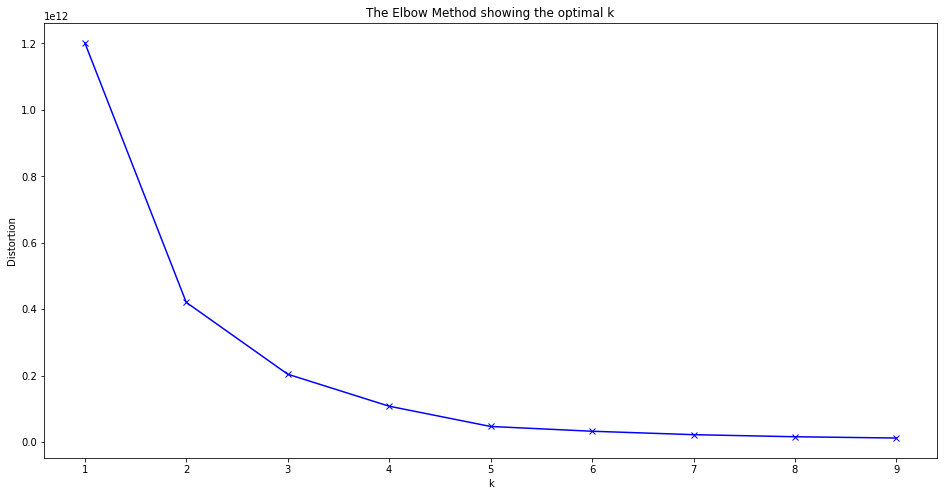

In [44]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(minneapolis_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [59]:
np.random.seed(0)
# from elbow method, set number of clusters to 3
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(minneapolis_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0], dtype=int32)

In [62]:
labels = kmeans.labels_
print(labels)

[0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 2 0 0 0
 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [77]:
neighborhoods_venues_sorted.shape

(85, 11)

In [76]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Armatage, Minneapolis",Pizza Place,Convenience Store,Food,Flower Shop,Trail,Park,Skate Park,Yoga Studio,Fast Food Restaurant,Football Stadium
1,"Audubon Park, Minneapolis",Pharmacy,Cosmetics Shop,Convenience Store,Hotel Bar,Thrift / Vintage Store,Park,Restaurant,Flea Market,Coffee Shop,Clothing Store
2,"Bancroft, Minneapolis",Ice Cream Shop,Caribbean Restaurant,Garden Center,Discount Store,Distillery,Flea Market,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Football Stadium
3,"Beltrami, Minneapolis",Brewery,Bus Station,Hot Spring,Playground,Café,Gay Bar,Asian Restaurant,Chinese Restaurant,Coffee Shop,Flower Shop
4,"Bottineau, Minneapolis",Park,Bar,Theme Restaurant,Bus Station,Beer Garden,Gym,Coffee Shop,German Restaurant,Food & Drink Shop,Art Gallery


In [97]:
minneapolis_grouped = minneapolis_grouped.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='neighborhood')
minneapolis_grouped.head()

ValueError: columns overlap but no suffix specified: Index(['1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'],
      dtype='object')

In [96]:
# add clustering labels
minneapolis_grouped["Labels"] = labels
minneapolis_grouped.head(5)

,neighborhood,latitude,longitude,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized,ATM,Acupuncturist,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Border Crossing,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridge,Building,Burger Joint,Bus Station,Butcher,Café,Caribbean Restaurant,Carpet Store,Casino,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Rec Center,College Residence Hall,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Dance Studio,Deli / Bodega,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Library,Light Rail Station,Liquor Store,Malay Restaurant,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,New American Restaurant,Non-Profit,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pilates Studio,Pizza Place,Playground,Plaza,Print Shop,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Wine Bar,Winery,Women's Store,Yoga Studio,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Labels
0,"Armatage, Minneapolis",44.897236,-93.310342,360400.0,0.2,0.5,2.5,5.1,4.2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.142857,0.142857,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.

In [98]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(minneapolis_grouped['latitude'], minneapolis_grouped['longitude'], minneapolis_grouped['neighborhood'], minneapolis_grouped['Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [156]:
#examine clusters

#CLUSTER 1

minneapolis_grouped.loc[minneapolis_grouped['Labels'] == 0, minneapolis_grouped.columns[[0, 3, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2]]]



,neighborhood,zestimatedHVI,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Armatage, Minneapolis",360400.0,Pizza Place,Convenience Store,Food,Flower Shop,Trail,Park,Skate Park,Yoga Studio,Fast Food Restaurant,Football Stadium
1,"Audubon Park, Minneapolis",289500.0,Pharmacy,Cosmetics Shop,Convenience Store,Hotel Bar,Thrift / Vintage Store,Park,Restaurant,Flea Market,Coffee Shop,Clothing Store
2,"Bancroft, Minneapolis",275200.0,Ice Cream Shop,Caribbean Restaurant,Garden Center,Discount Store,Distillery,Flea Market,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Football Stadium
3,"Beltrami, Minneapolis",256000.0,Brewery,Bus Station,Hot Spring,Playground,Café,Gay Bar,Asian Restaurant,Chinese Restaurant,Coffee Shop,Flower Shop
4,"Bottineau, Minneapolis",282100.0,Park,Bar,Theme Restaurant,Bus Station,Beer Garden,Gym,Coffee Shop,German Restaurant,Food & Drink Shop,Art Gallery
5,"Bryant, Minneapolis",271300.0,Deli / Bodega,Moving Target,Dive Bar,Food Truck,Park,Fishing Spot,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Football Stadium
8,"Cedar-Riverside, Minneapolis",182900.0,Theater,Bar,Sandwich Place,Bus Station,Chinese Restaurant,Dive Bar,Sporting Goods Shop,Coffee Shop,Music Venue,Light Rail Station
9,"Central, Minneapolis",262800.0,Coffee Shop,Food Truck,Hotel,Bar,Yoga Studio,Event Space,Sushi Restaurant,Chinese Restaurant,Salad Place,Park
10,"Cleveland, Minneapolis",198600.0,Music Venue,Food Truck,Trail,Yoga Studio,Fish & Chips Shop,Fried Chicken Joint,French Restaurant,Football Stadium,Food Court,Food & Drink Shop
11,"Columbia Park, Minneapolis",252600.0,Gym,Skate Park,Motorcycle Shop,Moving Target,Dive Bar,Fishing Spot,Fried Chicken Joint,Discount Store,French Restaurant,Football Stadium


In [157]:
#CLUSTER 2

minneapolis_grouped.loc[minneapolis_grouped['Labels'] == 1, minneapolis_grouped.columns[[0, 3, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2]]]

,neighborhood,zestimatedHVI,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,"Bryn Mawr, Minneapolis",430100.0,Coffee Shop,Furniture / Home Store,Intersection,Massage Studio,Latin American Restaurant,Men's Store,Grocery Store,Antique Shop,Pizza Place,Food Truck
7,"Cedar-Isles-Dean, Minneapolis",534100.0,Bridge,Food,Sporting Goods Shop,Gym / Fitness Center,Tourist Information Center,Beach,American Restaurant,Speakeasy,French Restaurant,Football Stadium
16,"Downtown East, Minneapolis",554800.0,Coffee Shop,Pub,Hotel,Bar,Japanese Restaurant,Farmers Market,Burger Joint,Sandwich Place,Public Art,Park
18,"East Calhoun, Minneapolis",534000.0,Ice Cream Shop,Cosmetics Shop,Beach,Scenic Lookout,Bakery,Dog Run,Donut Shop,Fried Chicken Joint,French Restaurant,Football Stadium
19,"East Harriet, Minneapolis",401600.0,Garden,Intersection,Park,Other Great Outdoors,Flower Shop,Carpet Store,Pub,American Restaurant,Home Service,Fast Food Restaurant
20,"East Isles, Minneapolis",463200.0,Coffee Shop,Pizza Place,Mexican Restaurant,Boutique,Tea Room,Sushi Restaurant,Pharmacy,Electronics Store,Theater,Spa
26,"Fulton, Minneapolis",515500.0,Antique Shop,Pet Store,Art Gallery,Shipping Store,Thrift / Vintage Store,Mexican Restaurant,Gourmet Shop,Coffee Shop,Pizza Place,Bus Station
27,"Hale, Minneapolis",401000.0,Thrift / Vintage Store,Playground,Breakfast Spot,Furniture / Home Store,Dive Bar,Fishing Spot,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Football Stadium
35,"Kenny, Minneapolis",380400.0,Plaza,Construction & Landscaping,Park,Brewery,Yoga Studio,Fish & Chips Shop,Fried Chicken Joint,French Restaurant,Football Stadium,Food Truck
43,"Lowry Hill, Minneapolis",661900.0,Ice Cream Shop,Bar,Restaurant,Scandinavian Restaurant,Print Shop,Gift Shop,Liquor Store,Steakhouse,American Restaurant,Acupuncturist


In [158]:
#CLUSTER 3

minneapolis_grouped.loc[minneapolis_grouped['Labels'] == 2, minneapolis_grouped.columns[[0, 3, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2]]]

,neighborhood,zestimatedHVI,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
36,"Kenwood, Minneapolis",1017600.0,Arts & Crafts Store,Tailor Shop,Café,Baseball Field,American Restaurant,Skating Rink,Bakery,School,Park,Bookstore


In [159]:
minneapolis_grouped.groupby('Labels').mean()

,latitude,longitude,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized,ATM,Acupuncturist,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Border Crossing,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridge,Building,Burger Joint,Bus Station,Butcher,Café,Caribbean Restaurant,Carpet Store,Casino,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Rec Center,College Residence Hall,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Dance Studio,Deli / Bodega,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Library,Light Rail Station,Liquor Store,Malay Restaurant,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,New American Restaurant,Non-Profit,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pilates Studio,Pizza Place,Playground,Plaza,Print Shop,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Wine Bar,Winery,Women's Store,Yoga Studio
Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,44.967050,-93.260985,2.631118e+05,0.366667,1.001961,4.262745,7.454902,4.215686,0.000726,0.004902,0.002801,0.000726,0.012982,0.003501,0.001634,0.014956,0.002503,0.008111,0.0,0.007501,0.000726,0.018107,0.001849,0.015720,0.009804,0.003268,0.000654,0.004027,0.000654,0.001225,0.0,0.001471,0.009804,0.007540,0.002064,0.006209,0.012486,0.000000,0.001307,0.008561,0.015459,0.001634,0.016189,0.009477,0.000000,0.0,0.011934,0.011186,0.000654,0.056218,0.000654,0.0,0.000726,0.000000,0.000817,0.000726,0.014784,0.013455,0.007153,0.0,